In [2]:
import pandas as pd
from numpy import NaN
import re
import requests
import geopandas as gpd
import matplotlib.pyplot as plt

# Part 1 - Data Gathering

1. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2021. 

In [3]:

offense_type = "offense_description=BURGLARY- AGGRAVATED"
date_range = "$where=incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'"
endpoint = f'https://data.nashville.gov/resource/2u6v-ujjs.json?{offense_type}&{date_range}&$limit=25000'
response = requests.get(endpoint)

In [4]:
api_data = response.json()

In [5]:
agg_burglary_data_df = pd.DataFrame(api_data)

2. Census Information

In [6]:
census_tracts = pd.read_csv('data/census_tracts.csv')

# Part 2 - Spatial Joining and Data Merging

3. 2020 census tract shapes

In [7]:
census_tract_shapes = gpd.read_file('data/tl_2020_47_tract/tl_2020_47_tract.shp')
census_tract_shapes.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,175,925200,47175925200,9252,Census Tract 9252,G5020,S,227429512,1667739,+35.7438100,-085.4940227,"POLYGON ((-85.61516 35.76106, -85.61509 35.761..."
1,47,175,925000,47175925000,9250,Census Tract 9250,G5020,S,480712883,1225717,+35.6695378,-085.4220628,"POLYGON ((-85.60513 35.70854, -85.60511 35.708..."
2,47,003,950201,47003950201,9502.01,Census Tract 9502.01,G5020,S,121774227,0,+35.6517480,-086.5575518,"POLYGON ((-86.64406 35.64029, -86.64375 35.642..."
3,47,003,950202,47003950202,9502.02,Census Tract 9502.02,G5020,S,110617191,700793,+35.5845755,-086.5790796,"POLYGON ((-86.66377 35.58189, -86.66367 35.582..."
4,47,093,003300,47093003300,33,Census Tract 33,G5020,S,5860088,229299,+36.0020586,-083.8371218,"POLYGON ((-83.86208 35.99255, -83.86207 35.992..."


<AxesSubplot: >

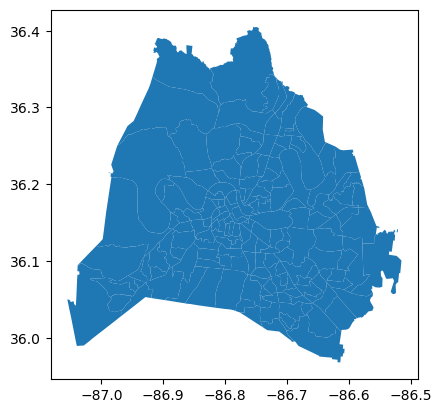

In [8]:
census_tract_shapes[census_tract_shapes['COUNTYFP']=='037'].plot()

In [9]:
davidson_county = census_tract_shapes[census_tract_shapes['COUNTYFP']=='037']

In [10]:
def coord_grabber(string):
    list = re.findall(r'\[([^]]+)\]',string)
    if len(list) == 1:
        return list[0]
    else:
        return list

In [11]:
test = agg_burglary_data_df['mapped_location']
coordinates = []

for elem in test:
    c = str(elem)
    coord = coord_grabber(c)
    coordinates.append(coord)

In [12]:
x = []
y = []
for string in coordinates:
    if type(string) == str:
        x.append(string.split(',')[0]) 
        y.append(string.split(',')[1])
    else:
        x.append(NaN)
        y.append(NaN)

In [13]:
agg_burglary_data_df['lat'] = y
agg_burglary_data_df['lng'] = x
agg_burglary_data_df[['lat', 'lng']] = agg_burglary_data_df[['lat', 'lng']].astype(float)

In [14]:
from shapely.geometry import Point
import shapely

In [15]:
agg_burglary_data_df['geometry'] = gpd.points_from_xy(agg_burglary_data_df['lng'], agg_burglary_data_df['lat'])

agg_burglary_data_df.head()

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_race,victim_ethnicity,victim_county_resident,mapped_location,rpa,zone,zip_code,lat,lng,geometry
0,20220167824_11,20220167824,D,DISPATCHED,O,OPEN,Open,2022-04-07T15:00:00.000,2022-04-08T11:52:00.000,JACKSON ST,...,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.8, 36.17]}",NaN,NaN,NaN,36.17,-86.80,POINT (-86.80000 36.17000)
1,20220126184_31,20220126184,D,DISPATCHED,O,OPEN,Open,2022-03-18T02:30:00.000,2022-03-18T06:51:00.000,BENTON AVE,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.13]}",8029,817,NaN,36.13,-86.77,POINT (-86.77000 36.13000)
2,20220027854_12,20220027854,D,DISPATCHED,O,OPEN,Open,2022-01-18T07:45:00.000,2022-01-19T23:48:00.000,CANE RIDGE RD,...,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.66, 36.04]}",NaN,NaN,NaN,36.04,-86.66,POINT (-86.66000 36.04000)
3,20220032825_11,20220032825,D,DISPATCHED,O,OPEN,Open,2022-01-23T00:40:00.000,2022-01-24T06:57:00.000,BROOKWOOD TER,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.86, 36.13]}",5019,121,NaN,36.13,-86.86,POINT (-86.86000 36.13000)
4,20220010799_11,20220010799,D,DISPATCHED,O,OPEN,Open,2021-12-06T12:00:00.000,2022-01-21T16:25:00.000,SOUTH ST,...,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.15]}",6805,815,NaN,36.15,-86.78,POINT (-86.78000 36.15000)


In [16]:
burglary_geo = gpd.GeoDataFrame(agg_burglary_data_df, 
                           crs = davidson_county.crs, 
                           geometry = agg_burglary_data_df['geometry'])

<AxesSubplot: >

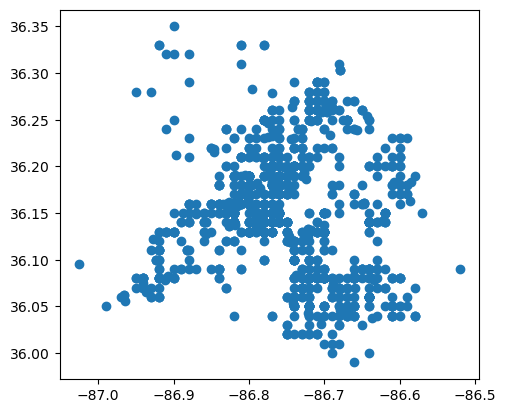

In [17]:
burglary_geo.plot()

In [18]:

burgs_by_tract = gpd.sjoin(burglary_geo, davidson_county, predicate='within')
burgs_by_tract.head()

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,20220167824_11,20220167824,D,DISPATCHED,O,OPEN,Open,2022-04-07T15:00:00.000,2022-04-08T11:52:00.000,JACKSON ST,...,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,+36.1669323,-086.8036511
148,20220285055_11,20220285055,D,DISPATCHED,O,OPEN,Open,2022-06-04T13:17:00.000,2022-06-09T13:17:00.000,IRELAND ST,...,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,+36.1669323,-086.8036511
192,20220059646_11,20220059646,D,DISPATCHED,O,OPEN,Open,2022-02-08T21:00:00.000,2022-02-08T22:49:00.000,14TH AVE N,...,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,+36.1669323,-086.8036511
260,20220070314_11,20220070314,D,DISPATCHED,O,OPEN,Open,2022-02-15T05:00:00.000,2022-02-15T11:10:00.000,IRELAND ST,...,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,+36.1669323,-086.8036511
267,20220420505_11,20220420505,S,SUSPECT,O,OPEN,Open,2022-08-24T01:00:00.000,2022-08-24T04:02:00.000,14TH AVE N,...,014200,47037014200,142,Census Tract 142,G5020,S,1080635,0,+36.1669323,-086.8036511


In [19]:
#Drop duplicate incidents of the same number, could be multiple victims for one burglary
burgs_by_tract = burgs_by_tract.drop_duplicates(subset=['incident_number'], keep='first')

In [20]:
print('These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. \n Census tract 163 had the most:')
burgs_by_tract['NAME'].value_counts()

These are the number of aggravated burglaries within in each of the census tracts in Davidson Co. 
 Census tract 163 had the most:


163       31
160       28
143       23
142       21
113       19
          ..
116        1
171        1
122        1
177.01     1
183.02     1
Name: NAME, Length: 163, dtype: int64

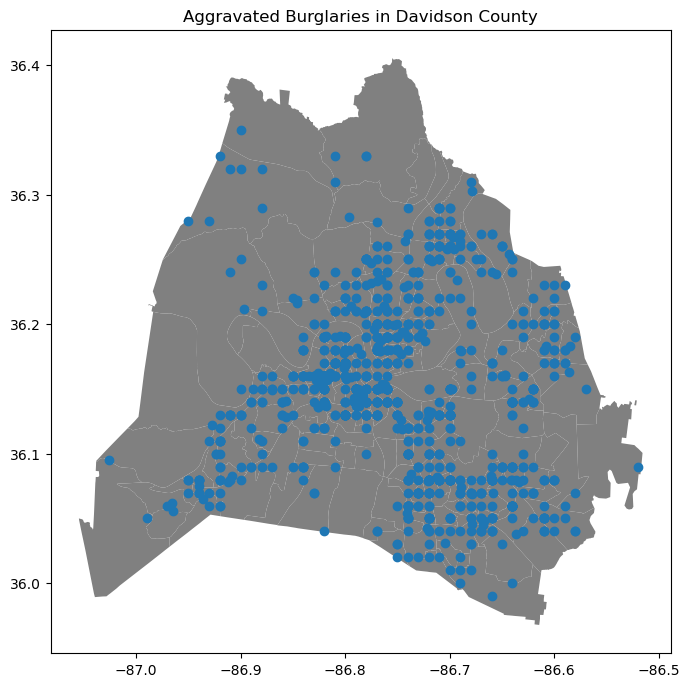

In [21]:
ax = davidson_county.plot(figsize = (8, 10), color = 'gray')
burgs_by_tract.plot( ax = ax);
ax.set_title('Aggravated Burglaries in Davidson County');

5. Merge census data 

In [22]:
#Adjust data types and column names to get ready for merge
burgs_by_tract['TRACTCE'] = burgs_by_tract['TRACTCE'].astype(int)
census_tracts = census_tracts.rename(columns={'tract':'TRACTCE'})

In [23]:
tracts_merged = pd.merge(burgs_by_tract, census_tracts, how='inner')
#Cleanup columns so we dont have unnecessary data
final_df_1 = tracts_merged[['incident_reported','geometry','TRACTCE','NAMELSAD', 'COUNTYFP', 'Population', 'median_income']]

In [24]:
final_df_1.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income
0,2022-04-08T11:52:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237
1,2022-06-09T13:17:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237
2,2022-02-08T22:49:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237
3,2022-02-15T11:10:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237
4,2022-08-24T04:02:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237


In [25]:
#Get the number of burglaries for each census tract area
fill=final_df_1['TRACTCE'].value_counts()
fill=fill.reset_index().rename(columns={'index': 'TRACTCE', 'TRACTCE': 'total_num_burgs_in_tract'})
fill.head()

,TRACTCE,total_num_burgs_in_tract
0,16300,31
1,16000,28
2,14300,23
3,14200,21
4,11300,19


In [26]:
#Now add the total num burgs for each census tract area with another merge
final_df_2 = pd.merge(final_df_1,fill,how='inner')
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract
0,2022-04-08T11:52:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21
1,2022-06-09T13:17:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21
2,2022-02-08T22:49:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21
3,2022-02-15T11:10:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21
4,2022-08-24T04:02:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21


In [27]:
#Now add column to calculate the burgs per 1000 residents
pop = final_df_2['Population']
tot_burgs_tract = final_df_2['total_num_burgs_in_tract']

final_df_2['burgs_per_1000'] = (tot_burgs_tract*1000)/pop

top_burgs_per_1000 = final_df_2[final_df_2['burgs_per_1000'] == final_df_2['burgs_per_1000'].max()]

print('The census tract with the highest number of burglaries per 1000 residents is', top_burgs_per_1000['NAMELSAD'].unique()[0], 'with', final_df_2['burgs_per_1000'].max(), 'burglaries per 1000 people.')

The census tract with the highest number of burglaries per 1000 residents is Census Tract 143 with 14.22387136672851 burglaries per 1000 people.


# Part 3 - Statistical Modeling

6. Explain the number of agg. burglaries using the median income of each census tract

In [28]:
final_df_2.head()

,incident_reported,geometry,TRACTCE,NAMELSAD,COUNTYFP,Population,median_income,total_num_burgs_in_tract,burgs_per_1000
0,2022-04-08T11:52:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21,10.135135
1,2022-06-09T13:17:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21,10.135135
2,2022-02-08T22:49:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21,10.135135
3,2022-02-15T11:10:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21,10.135135
4,2022-08-24T04:02:00.000,POINT (-86.80000 36.17000),14200,Census Tract 142,037,2072,24237,21,10.135135


In [29]:
median_income_pivot = (
            final_df_2
            .pivot_table(
                index = 'TRACTCE',
                values = ['median_income','Population','total_num_burgs_in_tract','burgs_per_1000']
            )
)
median_income_pivot.head()

,Population,burgs_per_1000,median_income,total_num_burgs_in_tract
TRACTCE,,,,
10103,2411,0.414766,60000,1
10104,3002,2.331779,84831,7
10105,4839,1.033271,61115,5
10106,2948,3.052917,66940,9
10201,4283,1.167406,69185,5


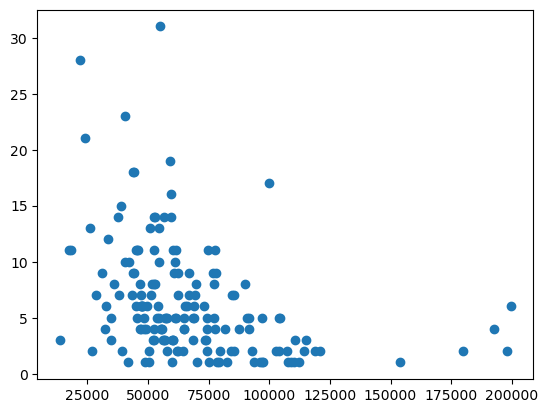

In [30]:
#Histogram with num burgs vs. median income
plt.scatter(median_income_pivot['median_income'], median_income_pivot['total_num_burgs_in_tract'])
plt.show()

7. Poisson Regression for rate of burglaries per census tract, predictor being the median income. 

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson
from ipywidgets import interact, FloatSlider, IntSlider

In [34]:
p_fit = smf.glm('burgs_per_1000 ~ median_income',
                 data = median_income_pivot,
                 family = sm.families.Poisson()
                 ).fit()

p_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         burgs_per_1000   No. Observations:                  163
Model:                            GLM   Df Residuals:                      161
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -276.14
Date:                Tue, 25 Oct 2022   Deviance:                       190.60
Time:                        17:58:35   Pearson chi2:                     274.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2576
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6130      0.158     10.188      0.000       1.303       1.923
median_income -1.667e-05   2.64e-06     -6.320      0.000   -2.18e-05   -1.15e-05
=================================================================================
"""